In [1]:
import gym4real.envs.trading
import numpy as np
import matplotlib.pyplot as plt
from gym4real.envs.trading.utils import parameter_generator
import gymnasium as gym
import random

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/giovannidispoto/Desktop/PhD/gym4ReaL_github/gym4ReaL


In [3]:
params = parameter_generator(world_options='gym4real/envs/trading/world_benchmark.yaml', seed=1234)
env_bnh = gym.make(id="gym4real/TradingEnv-v0", **{'settings':params})
env_snh = gym.make(id="gym4real/TradingEnv-v0", **{'settings':params})

1
END EPISODE
Len Rew:  598
3
END EPISODE
Len Rew:  598
4
END EPISODE
Len Rew:  598
5
END EPISODE
Len Rew:  598
6
END EPISODE
Len Rew:  598
8
END EPISODE
Len Rew:  598
9
END EPISODE
Len Rew:  598
10
END EPISODE
Len Rew:  598
11
END EPISODE
Len Rew:  598
13
END EPISODE
Len Rew:  598
14
END EPISODE
Len Rew:  598
15
END EPISODE
Len Rew:  598
16
END EPISODE
Len Rew:  598
18
END EPISODE
Len Rew:  598
19
END EPISODE
Len Rew:  598
20
END EPISODE
Len Rew:  598
21
END EPISODE
Len Rew:  598
23
END EPISODE
Len Rew:  598
24
END EPISODE
Len Rew:  598
25
END EPISODE
Len Rew:  598
26
END EPISODE
Len Rew:  598
28
END EPISODE
Len Rew:  598
30
END EPISODE
Len Rew:  598
31
END EPISODE
Len Rew:  598
33
END EPISODE
Len Rew:  598
34
END EPISODE
Len Rew:  598
35
END EPISODE
Len Rew:  598
36
END EPISODE
Len Rew:  598
38
END EPISODE
Len Rew:  598
39
END EPISODE
Len Rew:  598
40
END EPISODE
Len Rew:  598
41
END EPISODE
Len Rew:  598
43
END EPISODE
Len Rew:  598
44
END EPISODE
Len Rew:  598
45
END EPISODE
Len Re

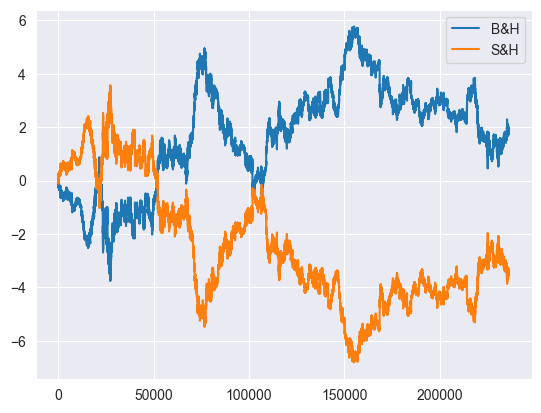

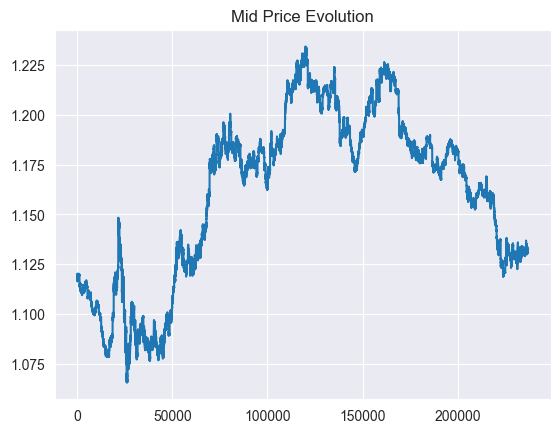

In [6]:
#Baseline -> B&L, S&L, Random
rewards_bnh = []
done = False
next_obs = None
reset = False
for i in range(env_bnh.unwrapped.get_trading_day_num()):
        obs, _ = env_bnh.reset()
        print(env_bnh.unwrapped._day)
        done = False
        reset = True
        episode_reward = []
        while not done:
          
          next_obs, reward, terminated, truncated, _ = env_bnh.step(2)
          
          #if done is True:
             #assert next_obs[env_bnh.get_state().index('Timestamp')] > 0.8
             #assert obs[env_bnh.get_state().index('Day')] == next_obs[env_bnh.get_state().index('Day')]
             #assert obs[env_bnh.get_state().index('Month')] == next_obs[env_bnh.get_state().index('Month')]
              
              
          obs = next_obs
          rewards_bnh.append(reward)
          episode_reward.append(reward)
          done = terminated or truncated
            
        print("END EPISODE")
        print("Len Rew: ", len(episode_reward))
        
rewards_snh = []
done = False
for i in range(env_snh.unwrapped.get_trading_day_num()):
    try:
        env_snh.reset()
        done = False
        while not done:
          next_obs, reward, terminated, truncated, _ = env_snh.step(0)
          rewards_snh.append(reward)
          done = terminated or truncated
    except:
        break
      
    
      
rewards_bnh = np.asarray(rewards_bnh)
rewards_snh = np.asarray(rewards_snh)

plt.plot((rewards_bnh.cumsum() / 100_000) * 100, label="B&H")
plt.plot((rewards_snh.cumsum() / 100_000) * 100 ,  label="S&H")
plt.legend()
plt.show()

plt.figure()
plt.title("Mid Price Evolution")
plt.plot(env_bnh.unwrapped._mid_prices, label="mid-price")
plt.show()